### degree -- home and work locations

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec

import geopandas as gpd
import shapely
from shapely.geometry import Point,Polygon,LineString

import json
import time
from copy import deepcopy

### data prep -- geo_edgelist saved in the end

In [11]:
# follower network -- data
edgelist = pd.read_csv('../data/usageousers_city_follower_networks.rpt.gz')

# read in data about individuals -- data2
userinfo = pd.read_csv('../data/usageousers_data_export_with_tract_geoid_top50.csv.gz', index_col=0)
user_geo = userinfo.loc[:,["user_id", "lat_home", "lon_home", "lat_work", "lon_work"]]

In [12]:
# edgelist with geoinfo
edgelist = pd.merge(pd.merge(edgelist, user_geo, left_on="user_id1", right_on="user_id", how="left"),\
               user_geo, left_on="user_id2", right_on="user_id", how="left", suffixes=("1", "2"))

# remove duplicate columns
edgelist = edgelist.loc[:,~edgelist.columns.duplicated()]

In [13]:
# DISTANCE - home-home part

start_time = time.time()

# geometry cols
edgelist["geometry1"] = edgelist.apply(lambda r: Point(r["lon_home1"],r["lat_home1"]), axis=1)
edgelist["geometry2"] = edgelist.apply(lambda r: Point(r["lon_home2"],r["lat_home2"]), axis=1)

geo_edgelist = gpd.GeoDataFrame(edgelist)

# change crs
geo_edgelist = geo_edgelist.set_geometry('geometry2')
geo_edgelist.crs = {'init': 'epsg:4326'}
geo_edgelist = geo_edgelist.to_crs({'init': 'epsg:3857'})

geo_edgelist = geo_edgelist.set_geometry('geometry1')
geo_edgelist.crs = {'init': 'epsg:4326'}
geo_edgelist = geo_edgelist.to_crs({'init': 'epsg:3857'})

# set geometry
geo_edgelist = geo_edgelist.set_geometry('geometry1')

# home-home distance calculation
geo_edgelist['dist_hh'] = geo_edgelist['geometry1'].distance(geo_edgelist['geometry2'])

print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


--- 390.20663619041443 seconds ---


In [5]:
# DISTANCE - work-work part

start_time = time.time()

# geometry cols
edgelist["geometry1"] = edgelist.apply(lambda r: Point(r["lon_work1"],r["lat_work1"]), axis=1)
edgelist["geometry2"] = edgelist.apply(lambda r: Point(r["lon_work2"],r["lat_work2"]), axis=1)

geo_edgelist2 = gpd.GeoDataFrame(edgelist)

# change crs
geo_edgelist2 = geo_edgelist2.set_geometry('geometry2')
geo_edgelist2.crs = {'init': 'epsg:4326'}
geo_edgelist2 = geo_edgelist2.to_crs({'init': 'epsg:3857'})

geo_edgelist2 = geo_edgelist2.set_geometry('geometry1')
geo_edgelist2.crs = {'init': 'epsg:4326'}
geo_edgelist2 = geo_edgelist2.to_crs({'init': 'epsg:3857'})

# set geometry
geo_edgelist2 = geo_edgelist2.set_geometry('geometry1')

# home-home distance calculation
geo_edgelist2['dist_ww'] = geo_edgelist2['geometry1'].distance(geo_edgelist2['geometry2'])

print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


--- 428.23562598228455 seconds ---


In [18]:
# combine..
temp = geo_edgelist2.loc[:,["cbsacode", "user_id1", "user_id2", "dist_ww"]]
geo_edgelist = pd.merge(geo_edgelist, temp, on=["cbsacode", "user_id1", "user_id2"], how="left")

In [22]:
# at this point, save the data!!
export = geo_edgelist.drop(columns=['geometry1', 'geometry2'])
export.to_csv("../data/geo_edgelist_top50.csv.gz", compression="gzip", index=False)

### spatial distribution of ego networks

In [11]:
# data IN
geo_edgelist = pd.read_csv("../data/geo_edgelist_top50.csv.gz")

In [12]:
# bin distances
binsize=500

geo_edgelist["dh_bin"] = binsize*(geo_edgelist["dist_hh"]/binsize).map(int)+500
geo_edgelist["dw_bin"] = binsize*(geo_edgelist["dist_ww"]/binsize).map(int)+500

In [13]:
# degree table -- NOTE -- all ties are mutual
degree_tab = geo_edgelist.groupby("user_id1")["user_id2"].count().reset_index()
degree_tab.columns = ["user_id", "degree"]

In [14]:
# loop -- HOME
dh_table = degree_tab

for d in list(range(500, 10500, 500)):
    
    temp = geo_edgelist.loc[geo_edgelist.dh_bin == d,:].groupby("user_id1")["user_id2"].count().reset_index()
    temp.columns = ["user_id", ("dh"+str(d))]
    
    dh_table = pd.merge(dh_table, temp, on="user_id", how="left")

In [16]:
# loop -- WORK
dw_table = degree_tab

for d in list(range(500, 10500, 500)):
    
    temp = geo_edgelist.loc[geo_edgelist.dw_bin == d,:].groupby("user_id1")["user_id2"].count().reset_index()
    temp.columns = ["user_id", ("dw"+str(d))]
    
    dw_table = pd.merge(dw_table, temp, on="user_id", how="left")

In [17]:
# merge the resuls of the loops
d_table = pd.merge(dh_table, dw_table, on=["user_id", "degree"], how="left")

In [18]:
# remove users with less than 10 ties (!!!) AND replace NANs
d_table = d_table[d_table["degree"]>=10] 
d_table = d_table.fillna(0)

In [19]:
# get the share of each degree
for c in list(d_table.columns[2:,]):    
    d_table[str(c)+"_share"] = round((d_table[str(c)] / d_table["degree"]), 3)

In [34]:
# construct simple dataframe for plot
rownames = []
values = []
type1 = ["home"] * 20 + ["work"] * 20

for c in list(d_table.columns)[-40:]:
    rownames.append(str(c))
    values.append(np.mean(d_table[str(c)]))
    
frame = { 'dist': rownames , 'avg_degree_share': values, 'type': type1} 
result = pd.DataFrame(frame)

In [35]:
# cumulative shares -- percent of ties by distance
result["degree_share_cum"] = result.groupby("type")["avg_degree_share"].cumsum()

<ipython-input-12-b6f498d067bf>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels)
<ipython-input-12-b6f498d067bf>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels)


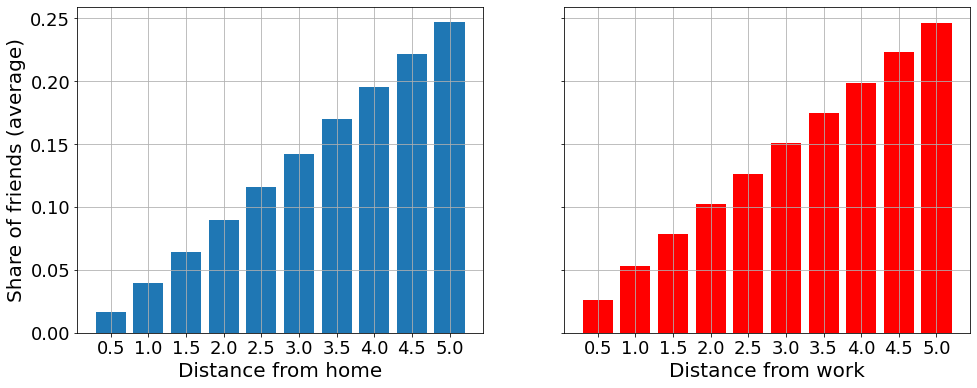

In [12]:
temp_home = result[result["type"]=="home"][:10]
temp_work = result[result["type"]=="work"][:10]

labels = list((np.linspace(0.5,5,10)))

plt.rcParams['font.size']=18
fig,ax = plt.subplots(1,2,figsize=(16,6), sharey=True)

ax[0].bar(temp_home["dist"], temp_home["degree_share_cum"])
ax[0].grid()
ax[0].set_xticklabels(labels)
ax[0].set_xlabel("Distance from home", size=20)
# ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 1)) 
ax[0].set_ylabel("Share of friends (average)", size=20)



ax[1].bar(temp_work["dist"], temp_work["degree_share_cum"], color="r")
ax[1].grid()
ax[1].set_xticklabels(labels)
ax[1].set_xlabel("Distance from work", size=20)

plt.show()

<ipython-input-13-6bdd6c37fb62>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


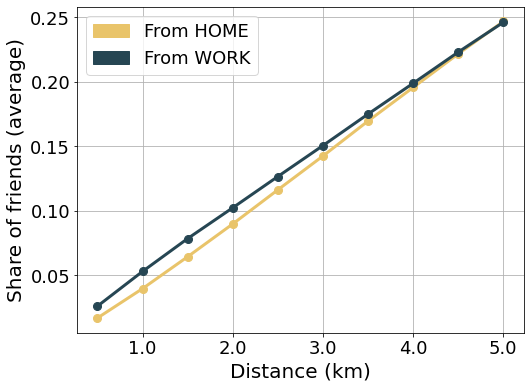

In [13]:
temp_home = result[result["type"]=="home"][:10]
temp_home["dist"] = list(range(500, 5500, 500))
temp_work = result[result["type"]=="work"][:10]
temp_work["dist"] = list(range(500, 5500, 500))

import matplotlib.patches as mpatches
plt.rcParams['font.size']=18
fig,ax = plt.subplots(1,1,figsize=(8,6), sharey=True)

labels = list((np.linspace(0,5,6)))

homep = ax.plot(temp_home["dist"], temp_home["degree_share_cum"], "o-", color="#e9c46a", linewidth=3, markersize=8)
workp = ax.plot(temp_work["dist"], temp_work["degree_share_cum"], "o-", color="#264653", linewidth=3, markersize=8)
ax.set_xticklabels(labels)

home_patch = mpatches.Patch(color='#e9c46a', label='From HOME')
work_patch = mpatches.Patch(color='#264653', label='From WORK')
ax.legend(handles=[home_patch, work_patch])

ax.set_xlabel("Distance (km)", size=20)
ax.set_ylabel("Share of friends (average)",  size=20)
ax.grid()
plt.show()

### futher issues
* home-work definitions + social netwoks (example) on MAP
* top50 metro areas average degree in 2km from H-W (similar to commuting)

### income and ego network distribution

In [16]:
# tract info
censusdata = pd.read_csv("../data/censusdata_top50_2012.csv")

# function to create tract geoids
def create_geoid(row):
    state = str(int(row["state"])).zfill(2)
    county = str(int(row["county"])).zfill(3)
    tract = str(int(row["tract"])).zfill(6)
    return "14000US" +state+county+tract

# geoid creation
censusdata['geoid'] = censusdata.apply(create_geoid,axis=1)

In [17]:
# userdata IN
userdata = pd.read_csv('../data/usageousers_data_export_with_tract_geoid_top50.csv.gz', index_col=0)

# remove bots
bot_flags = json.load(open("../data/bot_flags.json"))
userdata['drop'] = userdata['user_id'].map(int).map(str).map(bot_flags)
userdata = userdata[userdata['drop']==0]

In [18]:
## add cbsacodes to census tract level dataframe
temp = userdata.loc[:,['cbsacode', 'tract_home']].drop_duplicates()

# merge cbsacodes
census_df = pd.merge(censusdata, temp, left_on="geoid", right_on="tract_home", how="left")
census_df = census_df.drop(columns=("tract_home"))

# further filters
census_df = census_df[(census_df['income'] > 0)]

# remove NAs...
census_df = census_df.dropna()
census_df.shape

(38355, 23)

In [19]:
# get income percentiles by cbsacode
percentile = 25
census_df["income_lim1"] = census_df.cbsacode.map(census_df.groupby("cbsacode")['income']\
                                                  .quantile(percentile/100).to_dict())

census_df["income_lim2"] = census_df.cbsacode.map(census_df.groupby("cbsacode")['income']\
                                                  .quantile(1-percentile/100).to_dict())

In [20]:
# merging the user data and census data both on home and work census tracts
temp = pd.merge(userdata, census_df, left_on=["cbsacode", "tract_home"], right_on=["cbsacode", "geoid"], how="left")

# poor / rich dummies
po = (temp['income'] < temp["income_lim1"])
temp['poor'] = po.astype(int)

ri = (temp['income'] > temp["income_lim2"])
temp['rich'] = ri.astype(int)

# keep the necessary cols
temp = temp.loc[:,["user_id", "poor", "rich"]]

In [21]:
# data IN -- degree part
geo_edgelist = pd.read_csv("../data/geo_edgelist_top50.csv.gz")

In [22]:
# bin distances
binsize=500

geo_edgelist["dh_bin"] = binsize*(geo_edgelist["dist_hh"]/binsize).map(int)+500
geo_edgelist["dw_bin"] = binsize*(geo_edgelist["dist_ww"]/binsize).map(int)+500

In [23]:
# degree table -- NOTE -- all ties are mutual
degree_tab = geo_edgelist.groupby("user_id1")["user_id2"].count().reset_index()
degree_tab.columns = ["user_id", "degree"]

In [24]:
degree_tab = pd.merge(degree_tab, temp, on="user_id", how="inner")

In [25]:
# loop -- HOME
dh_table = degree_tab

for d in list(range(500, 10500, 500)):
    
    temp = geo_edgelist.loc[geo_edgelist.dh_bin == d,:].groupby("user_id1")["user_id2"].count().reset_index()
    temp.columns = ["user_id", ("dh"+str(d))]
    
    dh_table = pd.merge(dh_table, temp, on="user_id", how="left")

In [26]:
# loop -- WORK
dw_table = degree_tab

for d in list(range(500, 10500, 500)):
    
    temp = geo_edgelist.loc[geo_edgelist.dw_bin == d,:].groupby("user_id1")["user_id2"].count().reset_index()
    temp.columns = ["user_id", ("dw"+str(d))]
    
    dw_table = pd.merge(dw_table, temp, on="user_id", how="left")

In [27]:
# merge the resuls of the loops
dw_table = dw_table.drop(columns=["poor", "rich"])
d_table = pd.merge(dh_table, dw_table, on=["user_id", "degree"], how="left")

In [28]:
# remove users with less than 10 ties (!!!) AND replace NANs
d_table = d_table[d_table["degree"]>=10] 
d_table = d_table.fillna(0)
d_table.shape

(85077, 44)

In [29]:
# get the share of each degree
for c in list(d_table.columns[2:,]):    
    d_table[str(c)+"_share"] = round((d_table[str(c)] / d_table["degree"]), 3)

In [30]:
# poor users
d_poor = d_table[d_table["poor"]==1]

# rich users
d_rich = d_table[d_table["rich"]==1]

In [31]:
# construct simple dataframe for plot
rownames = []
values = []
type1 = ["home"] * 20 + ["work"] * 20

for c in list(d_poor.columns)[-40:]:
    rownames.append(str(c))
    values.append(np.mean(d_poor[str(c)]))
    
frame = { 'dist': rownames , 'avg_degree_share': values, 'type': type1} 
result_poor = pd.DataFrame(frame)

In [32]:
# construct simple dataframe for plot
rownames = []
values = []
type1 = ["home"] * 20 + ["work"] * 20

for c in list(d_rich.columns)[-40:]:
    rownames.append(str(c))
    values.append(np.mean(d_rich[str(c)]))
    
frame = { 'dist': rownames , 'avg_degree_share': values, 'type': type1} 
result_rich = pd.DataFrame(frame)

In [33]:
# cumulative shares -- percent of ties by distance
result_poor["degree_share_cum"] = result_poor.groupby("type")["avg_degree_share"].cumsum()
result_rich["degree_share_cum"] = result_rich.groupby("type")["avg_degree_share"].cumsum()

<ipython-input-35-fc4c552f9e99>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,0].set_xticklabels(labels)
<ipython-input-35-fc4c552f9e99>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,1].set_xticklabels(labels)
<ipython-input-35-fc4c552f9e99>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1,0].set_xticklabels(labels)
<ipython-input-35-fc4c552f9e99>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1,1].set_xticklabels(labels)


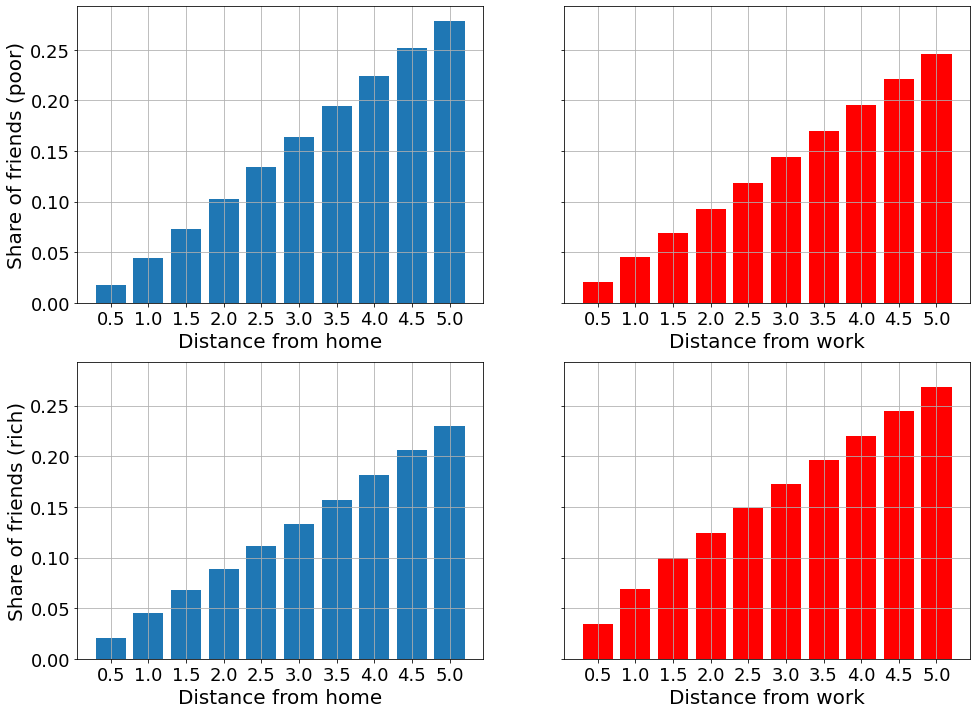

In [35]:
temp_home_poor = result_poor[result_poor["type"]=="home"][:10]
temp_work_poor = result_poor[result_poor["type"]=="work"][:10]

temp_home_rich = result_rich[result_rich["type"]=="home"][:10]
temp_work_rich = result_rich[result_rich["type"]=="work"][:10]

labels = list((np.linspace(0.5,5,10)))

plt.rcParams['font.size']=18
fig,ax = plt.subplots(2,2, figsize=(16,12), sharey=True)

ax[0,0].bar(temp_home_poor["dist"], temp_home_poor["degree_share_cum"])
ax[0,0].grid()
ax[0,0].set_xticklabels(labels)
ax[0,0].set_xlabel("Distance from home", size=20)
ax[0,0].set_ylabel("Share of friends (poor)", size=20)

ax[0,1].bar(temp_work_poor["dist"], temp_work_poor["degree_share_cum"], color="r")
ax[0,1].grid()
ax[0,1].set_xticklabels(labels)
ax[0,1].set_xlabel("Distance from work", size=20)

ax[1,0].bar(temp_home_rich["dist"], temp_home_rich["degree_share_cum"])
ax[1,0].grid()
ax[1,0].set_xticklabels(labels)
ax[1,0].set_xlabel("Distance from home", size=20)
ax[1,0].set_ylabel("Share of friends (rich)", size=20)

ax[1,1].bar(temp_work_rich["dist"], temp_work_rich["degree_share_cum"], color="r")
ax[1,1].grid()
ax[1,1].set_xticklabels(labels)
ax[1,1].set_xlabel("Distance from work", size=20)

plt.show()

<ipython-input-36-b756d1c26e4b>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


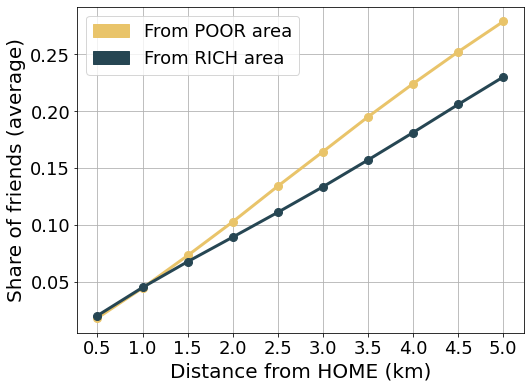

In [36]:
import matplotlib.patches as mpatches
plt.rcParams['font.size']=18
fig,ax = plt.subplots(1,1,figsize=(8,6), sharey=True)

labels = list((np.linspace(0.5,5,10)))

home_poor = ax.plot(temp_home_poor["dist"], temp_home_poor["degree_share_cum"], "o-", color="#e9c46a", linewidth=3, markersize=8)
home_rich = ax.plot(temp_home_rich["dist"], temp_home_rich["degree_share_cum"], "o-", color="#264653", linewidth=3, markersize=8)
ax.set_xticklabels(labels)

home_patch = mpatches.Patch(color='#e9c46a', label='From POOR area')
work_patch = mpatches.Patch(color='#264653', label='From RICH area')
ax.legend(handles=[home_patch, work_patch])

ax.set_xlabel("Distance from HOME (km)", size=20)
ax.set_ylabel("Share of friends (average)",  size=20)
ax.grid()
plt.show()

<ipython-input-41-6baf713b722b>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


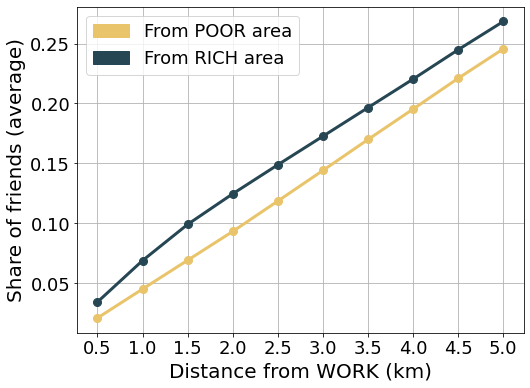

In [41]:
import matplotlib.patches as mpatches
plt.rcParams['font.size']=18
fig,ax = plt.subplots(1,1,figsize=(8,6), sharey=True)

labels = list((np.linspace(0.5,5,10)))

homep = ax.plot(temp_work_poor["dist"], temp_work_poor["degree_share_cum"], "o-", color="#e9c46a", linewidth=3, markersize=8)
workp = ax.plot(temp_work_rich["dist"], temp_work_rich["degree_share_cum"], "o-", color="#264653", linewidth=3, markersize=8)
ax.set_xticklabels(labels)

home_patch = mpatches.Patch(color='#e9c46a', label='From POOR area')
work_patch = mpatches.Patch(color='#264653', label='From RICH area')
ax.legend(handles=[home_patch, work_patch])

ax.set_xlabel("Distance from WORK (km)", size=20)
ax.set_ylabel("Share of friends (average)",  size=20)
ax.grid()
plt.show()

### gridspec combination

<ipython-input-59-c6029fba7228>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axbig.set_xticklabels(labelbig)
<ipython-input-59-c6029fba7228>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,1].set_xticklabels(labels12)
<ipython-input-59-c6029fba7228>:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1,1].set_xticklabels(labels12)


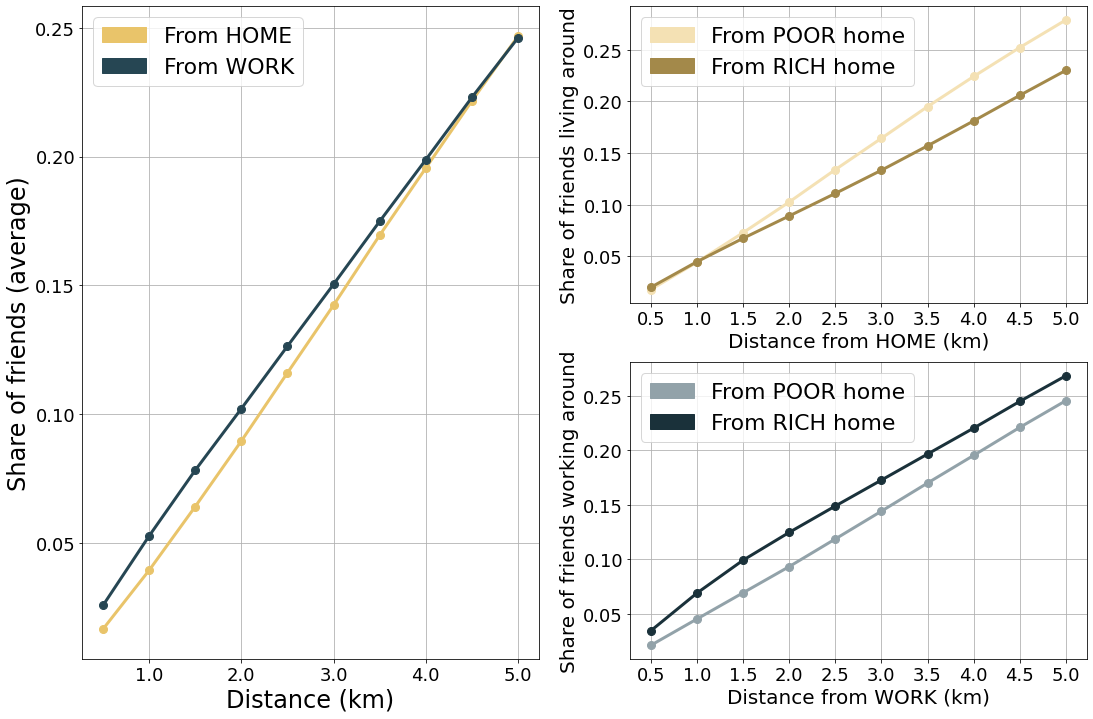

In [59]:
# combined figure

import matplotlib.patches as mpatches
plt.rcParams['font.size']=18
plt.rcParams["legend.fontsize"] = 22

fig,ax = plt.subplots(2,2,figsize=(18,12))
gs = ax[0,0].get_gridspec()

ax[0,0].remove()
ax[1,0].remove()

axbig = fig.add_subplot(gs[0:2,0])

labelbig = list((np.linspace(0,5,6)))
labels12 = list((np.linspace(0.5,5,10)))


# =====
# GENERAL figure
# =====

temp_home = result[result["type"]=="home"][:10]
temp_home["dist"] = list(range(500, 5500, 500))
temp_work = result[result["type"]=="work"][:10]
temp_work["dist"] = list(range(500, 5500, 500))

homep = axbig.plot(temp_home["dist"], temp_home["degree_share_cum"], "o-", color="#e9c46a", linewidth=3, markersize=8)
workp = axbig.plot(temp_work["dist"], temp_work["degree_share_cum"], "o-", color="#264653", linewidth=3, markersize=8)
axbig.set_xticklabels(labelbig)

home_patch = mpatches.Patch(color='#e9c46a', label='From HOME')
work_patch = mpatches.Patch(color='#264653', label='From WORK')
axbig.legend(handles=[home_patch, work_patch])

axbig.set_xlabel("Distance (km)", size=24)
axbig.set_ylabel("Share of friends (average)",  size=24)
axbig.grid()


# =====
# FROM HOME subplot
# =====

home_poor = ax[0,1].plot(temp_home_poor["dist"], temp_home_poor["degree_share_cum"], "o-", color="#f4e1b4", linewidth=3, markersize=8)
home_rich = ax[0,1].plot(temp_home_rich["dist"], temp_home_rich["degree_share_cum"], "o-", color="#a3894a", linewidth=3, markersize=8)
ax[0,1].set_xticklabels(labels12)

home_patch1 = mpatches.Patch(color='#f4e1b4', label='From POOR home')
work_patch1 = mpatches.Patch(color='#a3894a', label='From RICH home')
ax[0,1].legend(handles=[home_patch1, work_patch1])

ax[0,1].set_xlabel("Distance from HOME (km)", size=20)
ax[0,1].set_ylabel("Share of friends living around",  size=20)
ax[0,1].grid()


# =====
# FROM WORK subplot
# =====

work_poor = ax[1,1].plot(temp_work_poor["dist"], temp_work_poor["degree_share_cum"], "o-", color="#92a2a9", linewidth=3, markersize=8)
work_rich = ax[1,1].plot(temp_work_rich["dist"], temp_work_rich["degree_share_cum"], "o-", color="#1A313A", linewidth=3, markersize=8)
ax[1,1].set_xticklabels(labels12)

home_patch2 = mpatches.Patch(color='#92a2a9', label='From POOR home')
work_patch2 = mpatches.Patch(color='#1A313A', label='From RICH home')
ax[1,1].legend(handles=[home_patch2, work_patch2])

ax[1,1].set_xlabel("Distance from WORK (km)", size=20)
ax[1,1].set_ylabel("Share of friends working around",  size=20)
ax[1,1].grid()

plt.show()
#plt.savefig("../fig/gridspec_degree_plots.png", dpi=600, bbox_inches='tight')

In [ ]:
# overlap POOR / RICH overlap of users in 5 kms from home / work
# distance of POOR / RICH distance distribution between home / work

In [43]:
geo_edgelist.head()

,cbsacode,user_id1,user_id2,lat_home1,lon_home1,lat_work1,lon_work1,lat_home2,lon_home2,lat_work2,lon_work2,dist_hh,dist_ww
0,41860,18,12,37.929,-122.531,37.929,-122.531,37.618,-122.384,37.783,-122.405,46756.139445,24909.034778
1,41860,21,12,37.780,-122.410,37.780,-122.410,37.618,-122.384,37.783,-122.405,22974.986609,698.815956
2,41860,346,12,37.805,-122.270,37.792,-122.400,37.618,-122.384,37.783,-122.405,29213.970275,1384.539196
3,41860,1102,12,37.791,-122.429,37.616,-122.388,37.618,-122.384,37.783,-122.405,24851.472427,23571.654063
4,41860,1488,12,37.914,-122.477,37.782,-122.397,37.618,-122.384,37.783,-122.405,42948.744082,901.625481


In [42]:
# data IN
geo_edgelist = pd.read_csv("../data/geo_edgelist_top50.csv.gz")

In [5]:
# degree table -- NOTE -- all ties are mutual
degree_tab = geo_edgelist.groupby("user_id1")["user_id2"].count().reset_index()
degree_tab.columns = ["user_id", "degree"]

In [7]:
degree_tab.shape

(366632, 2)

In [9]:
distdata = degree_tab[degree_tab["degree"]>=10]

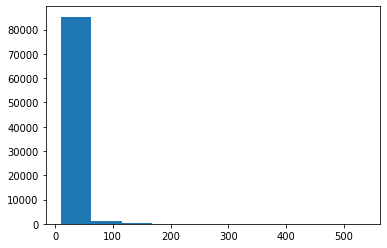

In [10]:
plt.hist(distdata.degree)
plt.show()

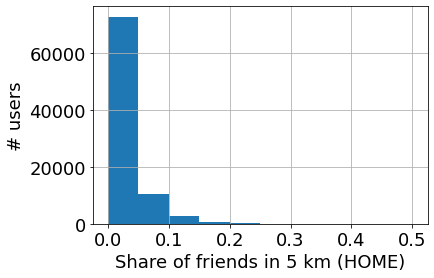

In [33]:
plt.rcParams['font.size']=18

plt.hist(d_table.dh10000_share)
plt.xlabel("Share of friends in 5 km (HOME)")
plt.ylabel("# users")
plt.grid()
plt.show()

In [36]:
result.head()

,dist,avg_degree_share,type,degree_share_cum
0,dh500_share,0.016605,home,0.016605
1,dh1000_share,0.022812,home,0.039417
2,dh1500_share,0.024729,home,0.064146
3,dh2000_share,0.025455,home,0.089601
4,dh2500_share,0.026463,home,0.116064


In [39]:
d_table["share_in5km"] = d_table.dh500_share + d_table.dh1000_share +\
    d_table.dh1500_share + d_table.dh2000_share +\
    d_table.dh2500_share + d_table.dh3000_share +\
    d_table.dh3500_share + d_table.dh4000_share +\
    d_table.dh4500_share + d_table.dh5000_share

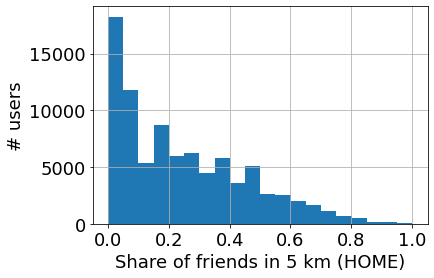

In [41]:
plt.rcParams['font.size']=18

plt.hist(d_table.share_in5km, bins=20)
plt.xlabel("Share of friends in 5 km (HOME)")
plt.ylabel("# users")
plt.grid()
plt.show()